<a href="https://colab.research.google.com/github/dcpatton/Image-Classification/blob/master/deep_weeds_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Weeds Classification with Vision Transformer

based on https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [27]:
!pip install tensorflow_datasets -U 

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (4.2.0)


In [28]:
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import random
print(tfds.__version__)

seed = 52
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)

4.2.0


# Get the Data

In [29]:
raw_ds = tfds.load('deep_weeds:3.0.0', as_supervised=True, shuffle_files=False, split='train')

images = []
labels = []
for image, label in raw_ds:
  images.append(image.numpy())
  labels.append(label.numpy())
X = np.asarray(images)
y = np.asarray(labels)

In [30]:
# calculate the weights for dealing with imbalance in the dataset
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.729283950617284, 1: 1.8284252297410193, 2: 1.8869490246793836, 3: 1.9035659926070885, 4: 1.8318685917555975, 5: 1.9280916198656535, 6: 1.8114007862611214, 7: 1.9148075240594926, 8: 0.21364423945139957}


In [31]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=seed)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (14007, 256, 256, 3) - y_train shape: (14007,)
x_test shape: (3502, 256, 256, 3) - y_test shape: (3502,)


In [32]:
num_classes = 9
num_epochs = 100
weight_decay = 0.0001
batch_size =32
image_size = 256  
patch_size = 16  
num_patches = (image_size // patch_size) ** 2
projection_dim = 64 # adjustable
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
transformer_layers = 8 # adjustable
mlp_head_units = [2048, 1024]  # adjustable

tf.keras.backend.clear_session()

In [33]:
data_augmentation = tf.keras.Sequential(
    [
        # tf.keras.layers.experimental.preprocessing.Normalization(),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), # horizontal_and_vertical
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.1, seed=seed),
        # tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.05, seed=seed),
        # tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.05, width_factor=0.05, seed=seed),
        tf.keras.layers.experimental.preprocessing.RandomCrop(height=240, width=240, seed=seed),
        tf.keras.layers.experimental.preprocessing.Resizing(image_size, image_size),
        tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(x_train)

In [34]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

In [35]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 256 X 256
Patch size: 16 X 16
Patches per image: 256
Elements per patch: 768


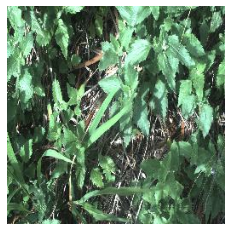

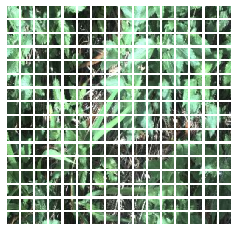

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [37]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# The Model

In [38]:
 input_shape = (256, 256, 3)
 
 def create_vit_classifier():
    inputs = tf.keras.layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = tf.keras.layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

# Train and Evaluate

In [39]:
def run_experiment(model):
    # optimizer = tfa.optimizers.AdamW(
    #     learning_rate=1e-3, weight_decay=weight_decay
    # )
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            # tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # checkpoint_filepath = "/tmp/checkpoint"
    # checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    #     checkpoint_filepath,
    #     monitor="val_accuracy",
    #     save_best_only=True,
    #     save_weights_only=True,
    # )

    es = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=500,
        validation_split=0.1,
        callbacks=[es],
        class_weight=class_weights,
        verbose=2,
    )

    # model.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"Loss: {loss}")
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/500
394/394 - 31s - loss: 2.7044 - accuracy: 0.1399 - val_loss: 2.0261 - val_accuracy: 0.1142
Epoch 2/500
394/394 - 22s - loss: 2.1370 - accuracy: 0.1607 - val_loss: 1.9300 - val_accuracy: 0.3062
Epoch 3/500
394/394 - 21s - loss: 2.0898 - accuracy: 0.1645 - val_loss: 2.1019 - val_accuracy: 0.2848
Epoch 4/500
394/394 - 22s - loss: 2.0651 - accuracy: 0.1689 - val_loss: 2.0193 - val_accuracy: 0.1378
Epoch 5/500
394/394 - 21s - loss: 2.0411 - accuracy: 0.1661 - val_loss: 1.9836 - val_accuracy: 0.1263
Epoch 6/500
394/394 - 21s - loss: 1.9817 - accuracy: 0.1866 - val_loss: 1.9551 - val_accuracy: 0.2163
Epoch 7/500
394/394 - 21s - loss: 1.8718 - accuracy: 0.2432 - val_loss: 1.8101 - val_accuracy: 0.2891
Epoch 8/500
394/394 - 21s - loss: 1.7383 - accuracy: 0.2895 - val_loss: 1.6663 - val_accuracy: 0.3876
Epoch 9/500
394/394 - 21s - loss: 1.6478 - accuracy: 0.3422 - val_loss: 1.4830 - val_accuracy: 0.4561
Epoch 10/500
394/394 - 21s - loss: 1.5661 - accuracy: 0.3589 - val_loss: 1.6390 - 